In [2]:
%matplotlib inline
import pylab
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import palettable as pal
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
import collections

In [3]:
import sys
sys.path.insert(0, '/Users/t/dev/sourmash')
import sourmash_lib
import sourmash_lib.fig
import sourmash_lib.signature

# Build hash co-occurrence matrix

Run:
```
./hashes-to-numpy-2.py ecoli_many_sigs/* {47,63}*.sig -o sigsubs -k 31 --threshold=2 --scaled=100000
```
to find all hashes that are present in two or more samples, across 50 ecoli genomes and two Shewanella genomes.

# Plot k-mer (hash) co-occurrence matrix

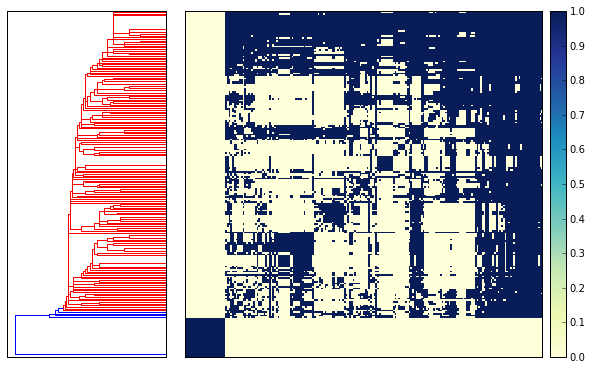

In [4]:
mat, labels = sourmash_lib.fig.load_matrix_and_labels('sigsubs')
_ = sourmash_lib.fig.plot_composite_matrix(mat, labels, show_labels=False, show_indices=False)


# Cluster and produce annotated dendrogram

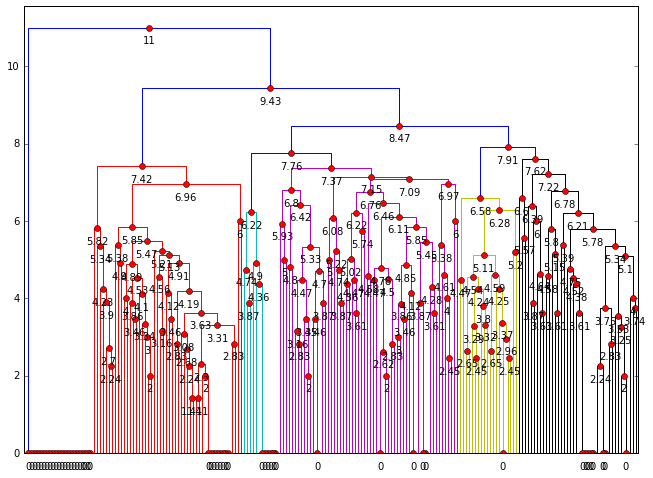

In [5]:
Y = sch.linkage(mat, method='average')

fig = pylab.figure(figsize=(11, 8))


def augmented_dendrogram(*args, **kwargs):

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

    return ddata

Z = augmented_dendrogram(Y, orientation='top', no_labels=True, labels=labels)


# Cut dendrogram into clusters

Looking at the annotated dendrogram above, choose a cut point
(below, `CUT_POINT=10` -> two clusters) and extract associated hash values from cluster.

cluster 1, 23 hashvals
cluster 2, 182 hashvals


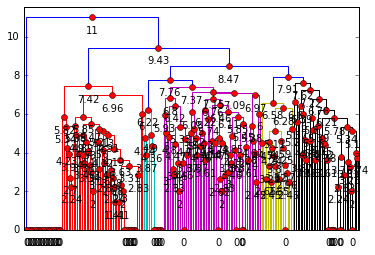

In [6]:
CUT_POINT=10
KSIZE=31
SCALED=100000

# redo load/clustering just for grins.
mat, labels = sourmash_lib.fig.load_matrix_and_labels('sigsubs')

Y = sch.linkage(mat, method='average')
cluster_ids = sch.fcluster(Y, t=CUT_POINT, criterion='distance')

Z = augmented_dendrogram(Y, orientation='top', no_labels=True, labels=labels)

# now, get leaves and leaf labels
idx1 = Z['leaves']
new_labels = Z['ivl']

# build clusters => sets of hashes.        
clusters = collections.defaultdict(set)

for i, k in enumerate(idx1):
    cluster_id = cluster_ids[k]
    clusters[cluster_id].add(int(new_labels[i]))
    
# output => signatures corresponding to each cluster on the original matrix

for cluster_id, hashvals in clusters.items():
    print('cluster {}, {} hashvals'.format(cluster_id, len(hashvals)))
    mh = sourmash_lib.MinHash(0, 31, max_hash=sourmash_lib.MAX_HASH / SCALED)
    for hashval in hashvals:
        mh.add_hash(hashval)
        
    sig_name = 'cluster {} (size {})'.format(cluster_id, len(hashvals))

    sig = sourmash_lib.signature.SourmashSignature('', mh, name=sig_name)
    sourmash_lib.signature.save_signatures([sig], open('cluster{}.sig'.format(cluster_id), 'wt'))

## Now, search cluster 1 against all the sigs

Here, 'cluster1' consists of all of the Shewanella hashes, which don't co-occur with any of the E. coli hashes. There should be 32 of them, representing about 3.2 Mbp of sequence.

Let's verify that cluster1 matches the Shewanella genomes:

```
sourmash search cluster1.sig {47,63}*.sig ecoli_many_sigs/*.sig -k 31
```

and you should see the results:

```
2 matches:
similarity   match
----------   -----
 56.1%       NC_009665.1 Shewanella baltica OS185, complete genome
 52.3%       NC_011663.1 Shewanella baltica OS223, complete genome
```

So! This shows how to extract MinHash signatures from a clustering on the hash co-occurrence matrix.  If we can get good clustering of hashes across many samples (ahem tara samples, E. coli pangenome, etc.) then we can extract signatures that match genetic elements that "hang out" together.

Note that the reason the similarity is so low is that we're looking only at hashes that are common between the two Shewanella genomes.

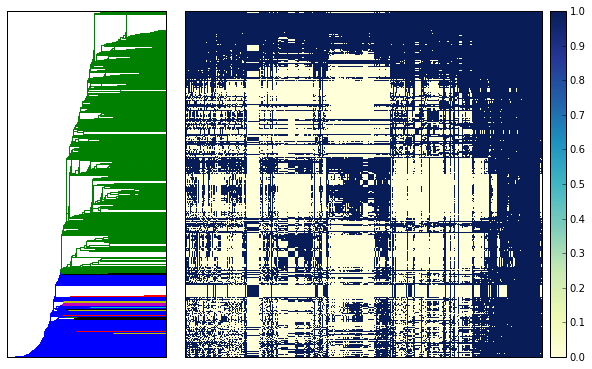

In [7]:
mat, labels = sourmash_lib.fig.load_matrix_and_labels('ecoli50')
_ = sourmash_lib.fig.plot_composite_matrix(mat, labels, show_labels=False, show_indices=False)
